In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
file_path_100 = "/home/asabzi/switch_ipg/ts_100Mbps"
file_path_1000 = "/home/asabzi/switch_ipg/ts_1000Mbps"
df_100 = pd.read_csv(file_path_100,names=['dummy_1', 'timestamp', 'dummy_2', 'seq'], delim_whitespace=True)
df_1000 = pd.read_csv(file_path_1000,names=['dummy_1', 'timestamp', 'dummy_2', 'seq'], delim_whitespace=True)


In [4]:
df_100.drop(columns=['dummy_1', 'dummy_2'], inplace=True)
df_1000.drop(columns=['dummy_1', 'dummy_2'], inplace=True)

In [5]:
df_rtx_1_100 = df_100.iloc[:-1,:].reset_index()
df_rtx_2_100 = df_100.iloc[1:,:].reset_index()
df_rtx_1_1000 = df_1000.iloc[:-1,:].reset_index()
df_rtx_2_1000 = df_1000.iloc[1:,:].reset_index()

df_100_diff = df_rtx_2_100 - df_rtx_1_100
df_1000_diff = df_rtx_2_1000 - df_rtx_1_1000


In [46]:
uniques = df_100_diff['seq'].unique()
print("Unique values in intervals for 100 Mbps: " )
print(uniques)

uniques = df_1000_diff['seq'].unique()
print("Unique values in intervals for 1000 Mbps: ")
print(uniques)

Unique values in intervals for 100 Mbps: 
[     1 -65535]
Unique values in intervals for 1000 Mbps: 
[     1 -65535     41     25     49     21     33      5     57     37
     17     29     39     27     65     69     13     32     61      9
     45     43     77      3      7     35     34     73     56     23
     26     38     28     31     30     12     72     53     22      6
     42     59     24 -65495     40     19     10     15     11     20
     18     71     67     47     62    129     55     81     51     46
     89     50 -65511     16     14     63     36     75 -65499     97
 -65497     64 -65503 -65507      4      8     60      2     79    193
     85 -65467     68     48     58     54     52 -65498     76 -65519
     66 -65515 -65471    225     83 -65501     92     78     80     87
 -65483 -65479     44    161 -65509     94 -65491     82     70 -65487
 -65475     84    134    185 -65523 -65477 -65505 -65463    164    125
     88 -65528 -65482    765  10944  11514   64

The average for intervals is: 4687.821899
The std for intervals is: 38053.379250
max interval is 327163
min interval is 11


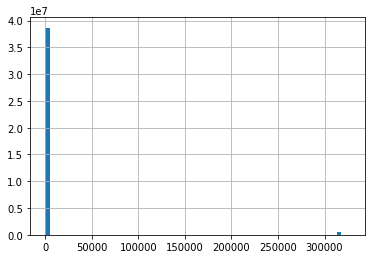

In [51]:
hist = (df_100_diff['timestamp']).hist(bins=70)
print("The average for intervals is: %f" % (df_100_diff['timestamp'].mean()))
print("The std for intervals is: %f" % (df_100_diff['timestamp'].std()))

print("max interval is " + str(df_100_diff['timestamp'].max()))
print("min interval is " + str(df_100_diff['timestamp'].min()))

In [53]:
coverage_percentage = 80
intervals = df_100_diff
lower_bound = int(((100-coverage_percentage)/100)/2 * len(intervals))
higher_bound = int(len(intervals) - lower_bound)
df_sorted_interals_100Mbps = intervals.sort_values(by=['timestamp'])
display(df_sorted_interals_100Mbps.head())
print(lower_bound)
print(higher_bound)
df_subIntervals_100Mbps = df_sorted_interals_100Mbps.iloc[lower_bound:higher_bound, :]
#print(len(intervals))
print(len(df_subIntervals_100Mbps)/len(intervals))

,index,timestamp,seq
16365947,1,11,1
19759735,1,11,1
26970873,1,11,1
35973695,1,11,1
28614734,1,11,1


3925253
35327286
0.8000000458569062


The average for intervals is: 25.525758
The std for intervals is: 7.569014
max interval is 72
min interval is 17


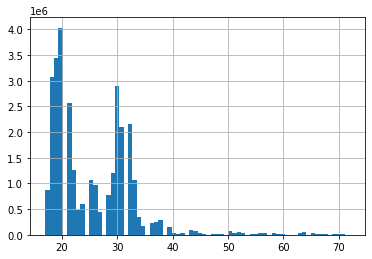

In [54]:
hist = (df_subIntervals_100Mbps['timestamp']).hist(bins=70)
print("The average for intervals is: %f" % (df_subIntervals_100Mbps['timestamp'].mean()))
print("The std for intervals is: %f" % (df_subIntervals_100Mbps['timestamp'].std()))

print("max interval is " + str(df_subIntervals_100Mbps['timestamp'].max()))
print("min interval is " + str(df_subIntervals_100Mbps['timestamp'].min()))